## TFT Architecture
GatedResidualNetwork

Core building block for feature processing and variable selection.
Applies layer normalization, dropout, and gated skip connections.

VariableSelectionNetwork:

Dynamically selects important features for the model using attention-like mechanisms.

TemporalFusionTransformer:

Encoder-Decoder architecture with:

Encoder for historical data processing.

Decoder for future data generation.

Output layer to predict the target variable



## Fine tuning, get the best hyperparameters, then use them in the next code cell

This step involves fine-tuning the models to obtain their best-performing hyperparameters. The process uses Optuna hyperparameter optimization techniques to identify the configurations that yield optimal performance metrics on validation data. The fine-tuned hyperparameters are then fixed and utilized in the subsequent code cell for performing rigorous 5-fold cross-validation, ensuring a consistent and fair evaluation of the models under optimized settings.


## Get the Best Hyperparameters:
Best Hyperparameters: {'hidden_size': 96, 'num_heads': 4, 'dropout': 0.12384863042284466, 'num_encoder_layers': 8, 'num_decoder_layers': 3, 'learning_rate': 0.0004808849148416016}

Best Validation Loss: 0.9811404380533431

## Cross-validation using the best hyperparameters

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import optuna
import warnings
warnings.filterwarnings('ignore')

def create_time_features(df):
    """Create time-based features from the datetime index"""
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(float)
    return df

class TemporalFusionTransformerDataset(Dataset):
    def __init__(self, data, time_varying_cols, target_col, 
                 encoder_steps=288, decoder_steps=144, is_training=True,
                 scalers=None):
        self.data = data
        self.time_varying_cols = time_varying_cols
        self.target_col = target_col
        self.encoder_steps = encoder_steps
        self.decoder_steps = decoder_steps
        self.is_training = is_training
        self.scalers = scalers if scalers is not None else {}
        
        # Optimize data preprocessing
        self.data = self.data.fillna(method='ffill').fillna(method='bfill')
        if scalers is None:
            self._fit_scalers()
        self._transform_data()
        
        # Pre-compute indices for faster __getitem__
        self.valid_indices = np.arange(len(self.data) - encoder_steps - decoder_steps + 1)
        
        # Convert to tensors once for efficiency
        self.features_tensor = torch.tensor(
            self.data[[f'{col}_scaled' for col in time_varying_cols]].values,
            dtype=torch.float32
        )
        self.target_tensor = torch.tensor(
            self.data[f'{target_col}_scaled'].values,
            dtype=torch.float32
        )

    def _fit_scalers(self):
        for col in self.time_varying_cols + [self.target_col]:
            scaler = StandardScaler()
            scaler.fit(self.data[col].values.reshape(-1, 1))
            self.scalers[col] = scaler

    def _transform_data(self):
        for col in self.time_varying_cols + [self.target_col]:
            self.data[f'{col}_scaled'] = self.scalers[col].transform(
                self.data[col].values.reshape(-1, 1)
            )

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        window_start = self.valid_indices[idx]
        window_end = window_start + self.encoder_steps + self.decoder_steps
        
        # Get encoder features (historical data)
        encoder_features = self.features_tensor[window_start:window_start + self.encoder_steps]
        
        # Get decoder features (future known inputs)
        if self.is_training:
            decoder_features = self.features_tensor[
                window_start + self.encoder_steps:window_end
            ]
        else:
            # For inference, repeat the last known features
            decoder_features = self.features_tensor[
                window_start + self.encoder_steps - 1:window_start + self.encoder_steps
            ].repeat(self.decoder_steps, 1)
        
        # Get target values (what we want to predict)
        target = self.target_tensor[window_start + self.encoder_steps:window_end].unsqueeze(-1)
        
        return {
            'encoder_inputs': encoder_features.unsqueeze(-1),
            'decoder_inputs': decoder_features.unsqueeze(-1),
            'target': target  # Shape will be [decoder_steps, 1]
        }

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(output_size)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.linear3 = nn.Linear(input_size, output_size)
        self.linear4 = nn.Linear(output_size, output_size)
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, x):
        # Use torch.jit.script on the forward method instead
        return self._forward_impl(x)
    
    @torch.jit.script_method
    def _forward_impl(self, x):
        skip = self.linear3(x)
        hidden = self.dropout_layer(F.elu(self.linear1(x)))
        hidden = self.linear2(hidden)
        gate = torch.sigmoid(self.linear4(hidden))
        return self.layer_norm(gate * hidden + skip)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, num_features, hidden_size=128, num_heads=4, dropout=0.1,
                 num_encoder_layers=3, num_decoder_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.feature_projection = nn.Linear(num_features, hidden_size)
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size, nhead=num_heads, 
                dim_feedforward=hidden_size * 4,
                dropout=dropout, batch_first=True
            ), 
            num_layers=num_encoder_layers
        )
        
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=hidden_size, nhead=num_heads,
                dim_feedforward=hidden_size * 4,
                dropout=dropout, batch_first=True
            ),
            num_layers=num_decoder_layers
        )
        
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, encoder_inputs, decoder_inputs):
        # Shape expected: 
        # encoder_inputs: [batch_size, encoder_steps, num_features, 1]
        # decoder_inputs: [batch_size, decoder_steps, num_features, 1]
        
        # Project features
        encoder_inputs = self.feature_projection(encoder_inputs.squeeze(-1))  # [batch_size, encoder_steps, hidden_size]
        decoder_inputs = self.feature_projection(decoder_inputs.squeeze(-1))  # [batch_size, decoder_steps, hidden_size]
        
        # Apply transformer layers
        encoder_output = self.encoder(encoder_inputs)  # [batch_size, encoder_steps, hidden_size]
        decoder_output = self.decoder(decoder_inputs, encoder_output)  # [batch_size, decoder_steps, hidden_size]
        
        # Generate predictions
        predictions = self.output_layer(decoder_output)  # [batch_size, decoder_steps, 1]
        return predictions

def train_tft_model(model, train_loader, val_loader, num_epochs=50, 
                   learning_rate=0.001, device='cuda', patience=10):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    val_losses = []
    
    # Enable automatic mixed precision for faster training
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            encoder_inputs = batch['encoder_inputs'].to(device)  # [batch, encoder_steps, features, 1]
            decoder_inputs = batch['decoder_inputs'].to(device)  # [batch, decoder_steps, features, 1]
            targets = batch['target'].to(device)  # [batch, decoder_steps, 1]
            
            with torch.cuda.amp.autocast():
                predictions = model(encoder_inputs, decoder_inputs)  # [batch, decoder_steps, 1]
                loss = criterion(predictions, targets)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.6f}')
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                encoder_inputs = batch['encoder_inputs'].to(device)
                decoder_inputs = batch['decoder_inputs'].to(device)
                targets = batch['target'].to(device)
                with torch.cuda.amp.autocast():
                    predictions = model(encoder_inputs, decoder_inputs)
                    loss = criterion(predictions, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f'Epoch {epoch}, Val Loss: {val_loss:.6f}')
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_tft_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
    
    model.load_state_dict(torch.load('best_tft_model.pth'))
    return model, val_losses

def objective(trial):
    # Simplified hyperparameter search space
    config = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_heads': trial.suggest_categorical('num_heads', [4, 8]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.3),
        'num_encoder_layers': trial.suggest_int('num_encoder_layers', 2, 4),
        'num_decoder_layers': trial.suggest_int('num_decoder_layers', 2, 4),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    }
    
    model = TemporalFusionTransformer(
        num_features=len(time_varying_cols),
        **{k: v for k, v in config.items() if k != 'learning_rate'}
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = TemporalFusionTransformerDataset(
        data=train_data, time_varying_cols=time_varying_cols,
        target_col='block_median_fee_rate', is_training=True
    )
    val_dataset = TemporalFusionTransformerDataset(
        data=val_data, time_varying_cols=time_varying_cols,
        target_col='block_median_fee_rate', is_training=False,
        scalers=train_dataset.scalers
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, 
                            num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, 
                          num_workers=2, pin_memory=True)
    
    _, val_losses = train_tft_model(
        model, train_loader, val_loader,
        num_epochs=30,  # Reduced from 50
        learning_rate=config['learning_rate'],
        device=device,
        patience=5  # Reduced from 10
    )
    return min(val_losses)

def main():
    print("Loading data...")
    df = pd.read_csv('/kaggle/input/tft-bitcoin/train_set.csv')
    df['block_time'] = pd.to_datetime(df['block_time'])
    df = df.sort_values('block_time').set_index('block_time')
    
    global time_varying_cols, train_data, val_data
    time_varying_cols = [
        'mempool_size_mb', 'mempool_min_fee', 'mempool_usage', 'total_fee',
        'avg_fee_rate', 'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th',
        'fee_rate_std', 'tx_count', 'transaction_count', 'block_interval',
        'block_weight', 'difficulty', 'hash_rate', 'bitcoin_price_usd',
        'hist_low_fee_ratio', 'hist_med_fee_ratio', 'hist_high_fee_ratio',
        'hist_fee_diversity', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
        'hour', 'dayofweek', 'is_weekend'
    ]
    
    df = create_time_features(df)
    split_idx = int(0.8 * len(df))
    train_data = df.iloc[:split_idx]
    val_data = df.iloc[split_idx:]
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)  # Reduced from 10
    print("\nBest Hyperparameters:", study.best_params)
    print("\nBest Validation Loss:", study.best_value)

if __name__ == "__main__":
    main()

[I 2025-01-06 18:01:05,204] A new study created in memory with name: no-name-1e425924-484c-474a-be79-f66502a880dc


Loading data...
Epoch 0, Train Loss: 0.193685
Epoch 0, Val Loss: 1.066328
Epoch 1, Train Loss: 0.093711
Epoch 1, Val Loss: 1.110444
Epoch 2, Train Loss: 0.073253
Epoch 2, Val Loss: 1.118799
Epoch 3, Train Loss: 0.062564
Epoch 3, Val Loss: 1.078796
Epoch 4, Train Loss: 0.055379
Epoch 4, Val Loss: 1.140904
Epoch 5, Train Loss: 0.049711


[I 2025-01-06 18:01:36,608] Trial 0 finished with value: 1.066328223546346 and parameters: {'hidden_size': 128, 'num_heads': 4, 'dropout': 0.2679995239946318, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'learning_rate': 0.00020423796408869857}. Best is trial 0 with value: 1.066328223546346.


Epoch 5, Val Loss: 1.132565
Early stopping at epoch 5
Epoch 0, Train Loss: 0.177789
Epoch 0, Val Loss: 0.928783
Epoch 1, Train Loss: 0.088390
Epoch 1, Val Loss: 0.925702
Epoch 2, Train Loss: 0.067986
Epoch 2, Val Loss: 0.994079
Epoch 3, Train Loss: 0.057428
Epoch 3, Val Loss: 0.968937
Epoch 4, Train Loss: 0.050111
Epoch 4, Val Loss: 0.972342
Epoch 5, Train Loss: 0.044141
Epoch 5, Val Loss: 0.994695
Epoch 6, Train Loss: 0.038866


[I 2025-01-06 18:02:32,041] Trial 1 finished with value: 0.9257022122542063 and parameters: {'hidden_size': 128, 'num_heads': 8, 'dropout': 0.11878133504279449, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'learning_rate': 0.00016350639365480429}. Best is trial 1 with value: 0.9257022122542063.


Epoch 6, Val Loss: 0.971493
Early stopping at epoch 6
Epoch 0, Train Loss: 0.239734
Epoch 0, Val Loss: 0.886980
Epoch 1, Train Loss: 0.071798
Epoch 1, Val Loss: 0.921143
Epoch 2, Train Loss: 0.053327
Epoch 2, Val Loss: 0.926039
Epoch 3, Train Loss: 0.042732
Epoch 3, Val Loss: 0.871031
Epoch 4, Train Loss: 0.036742
Epoch 4, Val Loss: 0.914470
Epoch 5, Train Loss: 0.030850
Epoch 5, Val Loss: 0.880426
Epoch 6, Train Loss: 0.025816
Epoch 6, Val Loss: 0.861631
Epoch 7, Train Loss: 0.023355
Epoch 7, Val Loss: 0.866107
Epoch 8, Train Loss: 0.020387
Epoch 8, Val Loss: 0.874981
Epoch 9, Train Loss: 0.018485
Epoch 9, Val Loss: 0.900892
Epoch 10, Train Loss: 0.017428
Epoch 10, Val Loss: 0.865934
Epoch 11, Train Loss: 0.015024


[I 2025-01-06 18:03:51,877] Trial 2 finished with value: 0.8616308649381001 and parameters: {'hidden_size': 128, 'num_heads': 4, 'dropout': 0.1858087846427492, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'learning_rate': 0.0009274436805499479}. Best is trial 2 with value: 0.8616308649381001.


Epoch 11, Val Loss: 0.915980
Early stopping at epoch 11
Epoch 0, Train Loss: 0.184038
Epoch 0, Val Loss: 0.808117
Epoch 1, Train Loss: 0.080417
Epoch 1, Val Loss: 0.902724
Epoch 2, Train Loss: 0.061203
Epoch 2, Val Loss: 0.948050
Epoch 3, Train Loss: 0.050929
Epoch 3, Val Loss: 0.893189
Epoch 4, Train Loss: 0.043743
Epoch 4, Val Loss: 0.939515
Epoch 5, Train Loss: 0.037792


[I 2025-01-06 18:05:00,059] Trial 3 finished with value: 0.8081174115339915 and parameters: {'hidden_size': 128, 'num_heads': 8, 'dropout': 0.2719026969155893, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.00034931905836224864}. Best is trial 3 with value: 0.8081174115339915.


Epoch 5, Val Loss: 0.937835
Early stopping at epoch 5
Epoch 0, Train Loss: 0.184617
Epoch 0, Val Loss: 0.901561
Epoch 1, Train Loss: 0.083006
Epoch 1, Val Loss: 0.880033
Epoch 2, Train Loss: 0.064637
Epoch 2, Val Loss: 0.853846
Epoch 3, Train Loss: 0.054920
Epoch 3, Val Loss: 0.838263
Epoch 4, Train Loss: 0.047469
Epoch 4, Val Loss: 0.870671
Epoch 5, Train Loss: 0.041651
Epoch 5, Val Loss: 0.852612
Epoch 6, Train Loss: 0.037453
Epoch 6, Val Loss: 0.834082
Epoch 7, Train Loss: 0.033233
Epoch 7, Val Loss: 0.825903
Epoch 8, Train Loss: 0.029990
Epoch 8, Val Loss: 0.876361
Epoch 9, Train Loss: 0.027182
Epoch 9, Val Loss: 0.867794
Epoch 10, Train Loss: 0.025169
Epoch 10, Val Loss: 0.910093
Epoch 11, Train Loss: 0.023348
Epoch 11, Val Loss: 0.858042
Epoch 12, Train Loss: 0.021434


[I 2025-01-06 18:06:26,319] Trial 4 finished with value: 0.8259028613567352 and parameters: {'hidden_size': 64, 'num_heads': 4, 'dropout': 0.26595900579442244, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.0006295776607337031}. Best is trial 3 with value: 0.8081174115339915.


Epoch 12, Val Loss: 0.840061
Early stopping at epoch 12
Epoch 0, Train Loss: 0.578540
Epoch 0, Val Loss: 1.031946
Epoch 1, Train Loss: 0.070114
Epoch 1, Val Loss: 1.035338
Epoch 2, Train Loss: 0.049384
Epoch 2, Val Loss: 1.086429
Epoch 3, Train Loss: 0.039346
Epoch 3, Val Loss: 1.032638
Epoch 4, Train Loss: 0.030678
Epoch 4, Val Loss: 0.951838
Epoch 5, Train Loss: 0.025055
Epoch 5, Val Loss: 0.995300
Epoch 6, Train Loss: 0.022539
Epoch 6, Val Loss: 0.967374
Epoch 7, Train Loss: 0.018058
Epoch 7, Val Loss: 0.897312
Epoch 8, Train Loss: 0.017316
Epoch 8, Val Loss: 0.945636
Epoch 9, Train Loss: 0.013711
Epoch 9, Val Loss: 0.940913
Epoch 10, Train Loss: 0.011732
Epoch 10, Val Loss: 0.918371
Epoch 11, Train Loss: 0.011107
Epoch 11, Val Loss: 0.935880
Epoch 12, Train Loss: 0.009658


[I 2025-01-06 18:09:27,387] Trial 5 finished with value: 0.8973117649555207 and parameters: {'hidden_size': 256, 'num_heads': 4, 'dropout': 0.13776134752707683, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'learning_rate': 0.0006773545957914532}. Best is trial 3 with value: 0.8081174115339915.


Epoch 12, Val Loss: 0.948464
Early stopping at epoch 12
Epoch 0, Train Loss: 0.198569
Epoch 0, Val Loss: 1.022700
Epoch 1, Train Loss: 0.099157
Epoch 1, Val Loss: 1.026170
Epoch 2, Train Loss: 0.079475
Epoch 2, Val Loss: 1.008634
Epoch 3, Train Loss: 0.068785
Epoch 3, Val Loss: 0.987813
Epoch 4, Train Loss: 0.061481
Epoch 4, Val Loss: 0.927614
Epoch 5, Train Loss: 0.055475
Epoch 5, Val Loss: 0.935335
Epoch 6, Train Loss: 0.050543
Epoch 6, Val Loss: 0.891969
Epoch 7, Train Loss: 0.046490
Epoch 7, Val Loss: 0.887524
Epoch 8, Train Loss: 0.043019
Epoch 8, Val Loss: 0.864431
Epoch 9, Train Loss: 0.039912
Epoch 9, Val Loss: 0.873981
Epoch 10, Train Loss: 0.036826
Epoch 10, Val Loss: 0.866286
Epoch 11, Train Loss: 0.035054
Epoch 11, Val Loss: 0.849732
Epoch 12, Train Loss: 0.033188
Epoch 12, Val Loss: 0.855142
Epoch 13, Train Loss: 0.030355
Epoch 13, Val Loss: 0.837973
Epoch 14, Train Loss: 0.028674
Epoch 14, Val Loss: 0.852454
Epoch 15, Train Loss: 0.027385
Epoch 15, Val Loss: 0.810850
Epoc

[I 2025-01-06 18:13:12,492] Trial 6 finished with value: 0.7766064623991649 and parameters: {'hidden_size': 64, 'num_heads': 8, 'dropout': 0.1498638001366655, 'num_encoder_layers': 4, 'num_decoder_layers': 2, 'learning_rate': 0.00024944416747950073}. Best is trial 6 with value: 0.7766064623991649.


Epoch 29, Val Loss: 0.790649
Epoch 0, Train Loss: 0.208428
Epoch 0, Val Loss: 0.919675
Epoch 1, Train Loss: 0.097893
Epoch 1, Val Loss: 0.904713
Epoch 2, Train Loss: 0.077972
Epoch 2, Val Loss: 0.863431
Epoch 3, Train Loss: 0.066258
Epoch 3, Val Loss: 0.794568
Epoch 4, Train Loss: 0.058598
Epoch 4, Val Loss: 0.782066
Epoch 5, Train Loss: 0.051854
Epoch 5, Val Loss: 0.783723
Epoch 6, Train Loss: 0.047011
Epoch 6, Val Loss: 0.780482
Epoch 7, Train Loss: 0.043375
Epoch 7, Val Loss: 0.788845
Epoch 8, Train Loss: 0.039337
Epoch 8, Val Loss: 0.824275
Epoch 9, Train Loss: 0.036367
Epoch 9, Val Loss: 0.798537
Epoch 10, Train Loss: 0.033717
Epoch 10, Val Loss: 0.822503
Epoch 11, Train Loss: 0.031419


[I 2025-01-06 18:14:20,913] Trial 7 finished with value: 0.7804824948310852 and parameters: {'hidden_size': 64, 'num_heads': 4, 'dropout': 0.1694120768263871, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'learning_rate': 0.0002639138441207519}. Best is trial 6 with value: 0.7766064623991649.


Epoch 11, Val Loss: 0.823148
Early stopping at epoch 11
Epoch 0, Train Loss: 0.216179
Epoch 0, Val Loss: 0.698105
Epoch 1, Train Loss: 0.083889
Epoch 1, Val Loss: 0.702299
Epoch 2, Train Loss: 0.064092
Epoch 2, Val Loss: 0.721810
Epoch 3, Train Loss: 0.053720
Epoch 3, Val Loss: 0.762831
Epoch 4, Train Loss: 0.046504
Epoch 4, Val Loss: 0.735277
Epoch 5, Train Loss: 0.040014


[I 2025-01-06 18:15:00,029] Trial 8 finished with value: 0.6981046597162882 and parameters: {'hidden_size': 64, 'num_heads': 4, 'dropout': 0.25990861704137086, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.0007495290955732481}. Best is trial 8 with value: 0.6981046597162882.


Epoch 5, Val Loss: 0.761914
Early stopping at epoch 5
Epoch 0, Train Loss: 0.382580
Epoch 0, Val Loss: 0.783555
Epoch 1, Train Loss: 0.081872
Epoch 1, Val Loss: 0.766250
Epoch 2, Train Loss: 0.058744
Epoch 2, Val Loss: 0.769921
Epoch 3, Train Loss: 0.046754
Epoch 3, Val Loss: 0.765904
Epoch 4, Train Loss: 0.041942
Epoch 4, Val Loss: 0.747254
Epoch 5, Train Loss: 0.033472
Epoch 5, Val Loss: 0.776843
Epoch 6, Train Loss: 0.028351
Epoch 6, Val Loss: 0.750910
Epoch 7, Train Loss: 0.025079
Epoch 7, Val Loss: 0.728754
Epoch 8, Train Loss: 0.021913
Epoch 8, Val Loss: 0.756658
Epoch 9, Train Loss: 0.019398
Epoch 9, Val Loss: 0.768857
Epoch 10, Train Loss: 0.017319
Epoch 10, Val Loss: 0.771086
Epoch 11, Train Loss: 0.015845
Epoch 11, Val Loss: 0.745527
Epoch 12, Train Loss: 0.014983


[I 2025-01-06 18:18:33,315] Trial 9 finished with value: 0.7287542482217153 and parameters: {'hidden_size': 256, 'num_heads': 4, 'dropout': 0.1291868046394982, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.00024484168586968774}. Best is trial 8 with value: 0.6981046597162882.


Epoch 12, Val Loss: 0.771697
Early stopping at epoch 12

Best Hyperparameters: {'hidden_size': 64, 'num_heads': 4, 'dropout': 0.25990861704137086, 'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.0007495290955732481}

Best Validation Loss: 0.6981046597162882


Loading data...
Starting cross-validation...

Training fold 1/5
Fold 1 indices:
Train data: 0 to 10945
Test data: 10657 to 11089
Train data shape: (10945, 32)
Test data shape: (432, 32)
Training on device: cuda
Epoch 5/100
Training Loss: 0.0244
Validation Loss: 1.9953
Epoch 10/100
Training Loss: 0.0116
Validation Loss: 2.6642
Early stopping triggered
Starting predictions...
Batch 0: Generated 144 predictions
Final predictions shape: (144,)
Final actuals shape: (144,)
Predictions range: [3.26, 11.93]
Actuals range: [3.11, 15.00]
Starting plot function
Original shapes - y_true: (144,), y_pred: (144,)
Number of valid points: 144
Plotting 144 points
y_true range: [3.11, 15.00]
y_pred range: [3.26, 11.93]


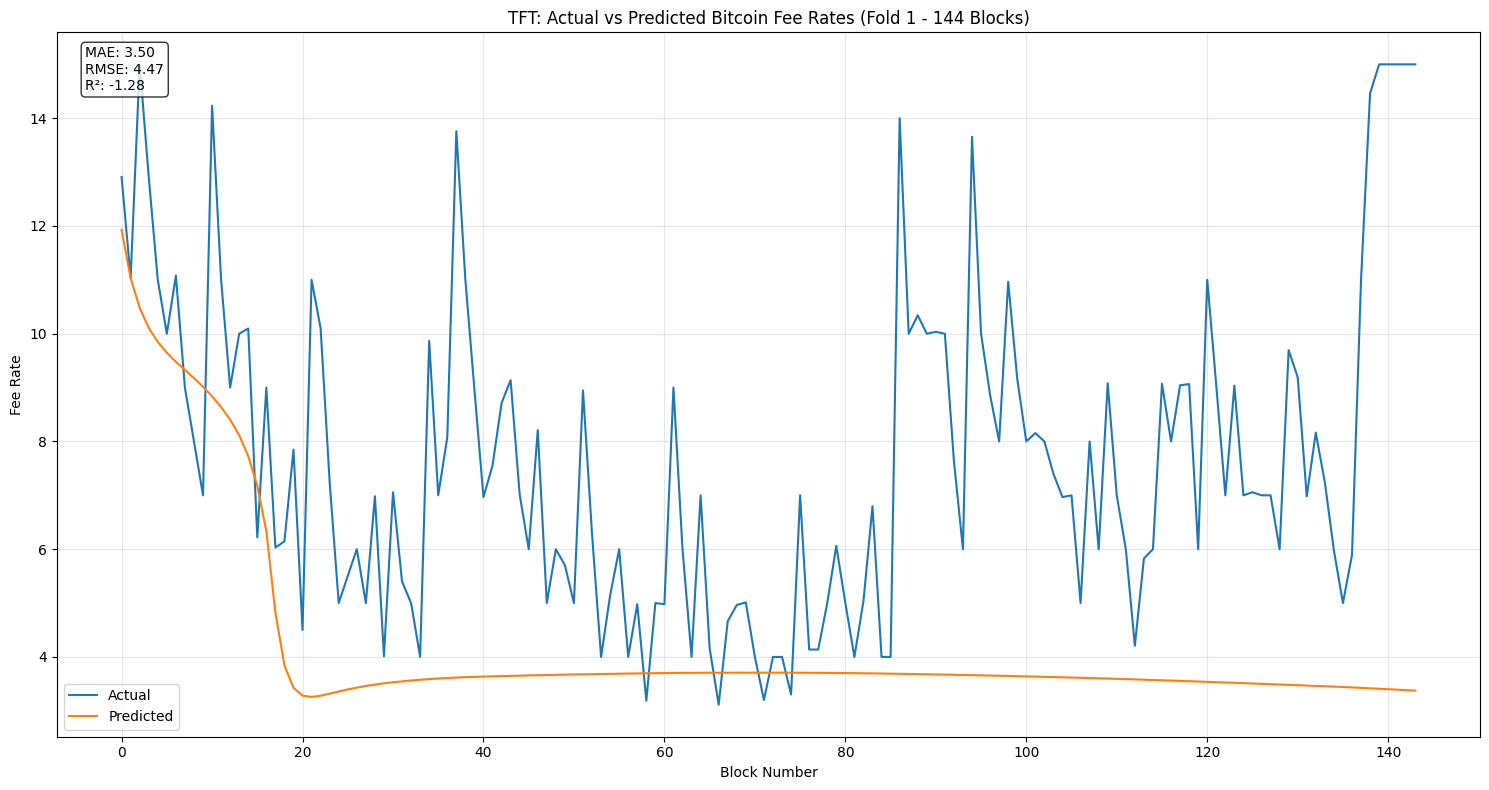


Analyzing feature importance...

Fold 1 Metrics:
MAE: 3.4965
RMSE: 4.4705
R2: -1.2792
MAPE: 40.7739
Theil_U: 0.6795

Training fold 2/5
Fold 2 indices:
Train data: 0 to 11089
Test data: 10801 to 11233
Train data shape: (11089, 32)
Test data shape: (432, 32)
Training on device: cuda
Epoch 5/100
Training Loss: 0.0240
Validation Loss: 1.0568
Epoch 10/100
Training Loss: 0.0119
Validation Loss: 1.3286
Early stopping triggered
Starting predictions...
Batch 0: Generated 144 predictions
Final predictions shape: (144,)
Final actuals shape: (144,)
Predictions range: [8.07, 14.90]
Actuals range: [3.00, 15.00]
Starting plot function
Original shapes - y_true: (144,), y_pred: (144,)
Number of valid points: 144
Plotting 144 points
y_true range: [3.00, 15.00]
y_pred range: [8.07, 14.90]


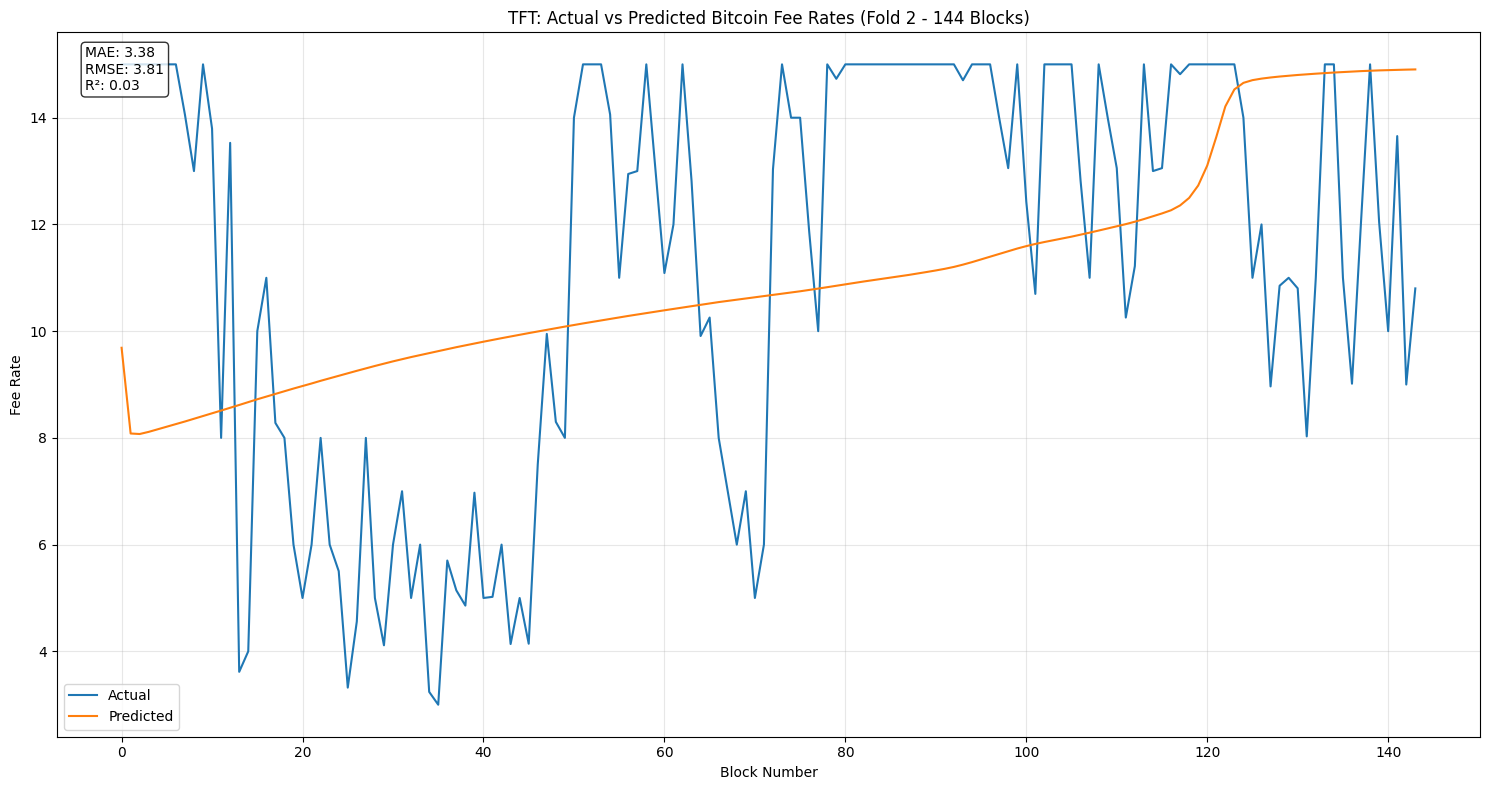


Analyzing feature importance...

Fold 2 Metrics:
MAE: 3.3779
RMSE: 3.8147
R2: 0.0346
MAPE: 39.4482
Theil_U: 0.5925

Training fold 3/5
Fold 3 indices:
Train data: 0 to 11233
Test data: 10945 to 11377
Train data shape: (11233, 32)
Test data shape: (432, 32)
Training on device: cuda
Epoch 5/100
Training Loss: 0.0236
Validation Loss: 0.8118
Epoch 10/100
Training Loss: 0.0111
Validation Loss: 0.8136
Early stopping triggered
Starting predictions...
Batch 0: Generated 144 predictions
Final predictions shape: (144,)
Final actuals shape: (144,)
Predictions range: [10.44, 15.71]
Actuals range: [6.00, 15.00]
Starting plot function
Original shapes - y_true: (144,), y_pred: (144,)
Number of valid points: 144
Plotting 144 points
y_true range: [6.00, 15.00]
y_pred range: [10.44, 15.71]


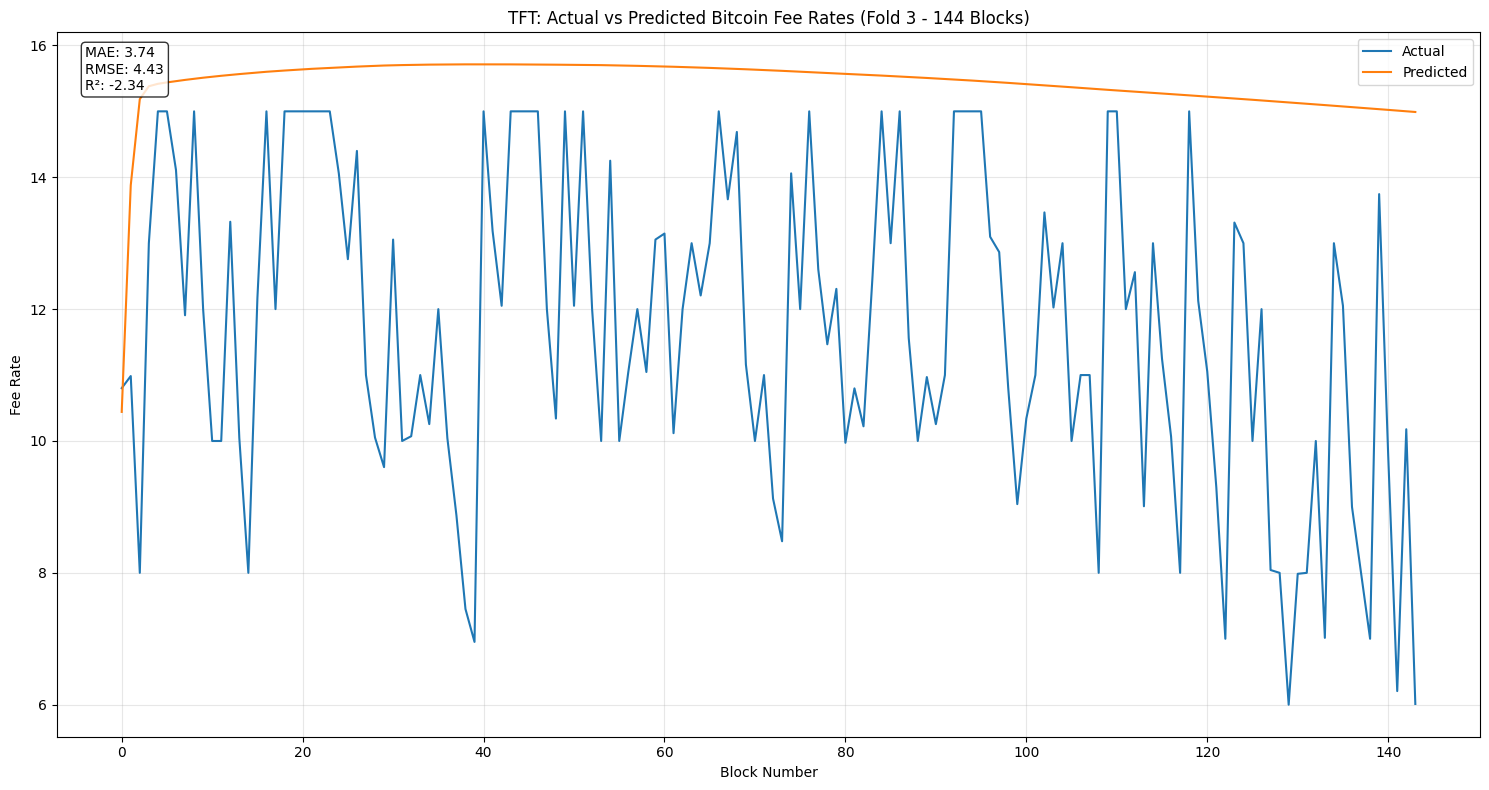


Analyzing feature importance...

Fold 3 Metrics:
MAE: 3.7442
RMSE: 4.4291
R2: -2.3402
MAPE: 38.5544
Theil_U: 0.5686

Training fold 4/5
Fold 4 indices:
Train data: 0 to 11377
Test data: 11089 to 11521
Train data shape: (11377, 32)
Test data shape: (432, 32)
Training on device: cuda
Epoch 5/100
Training Loss: 0.0239
Validation Loss: 0.4625
Epoch 10/100
Training Loss: 0.0113
Validation Loss: 0.5118
Early stopping triggered
Starting predictions...
Batch 0: Generated 144 predictions
Final predictions shape: (144,)
Final actuals shape: (144,)
Predictions range: [7.92, 10.19]
Actuals range: [3.00, 15.00]
Starting plot function
Original shapes - y_true: (144,), y_pred: (144,)
Number of valid points: 144
Plotting 144 points
y_true range: [3.00, 15.00]
y_pred range: [7.92, 10.19]


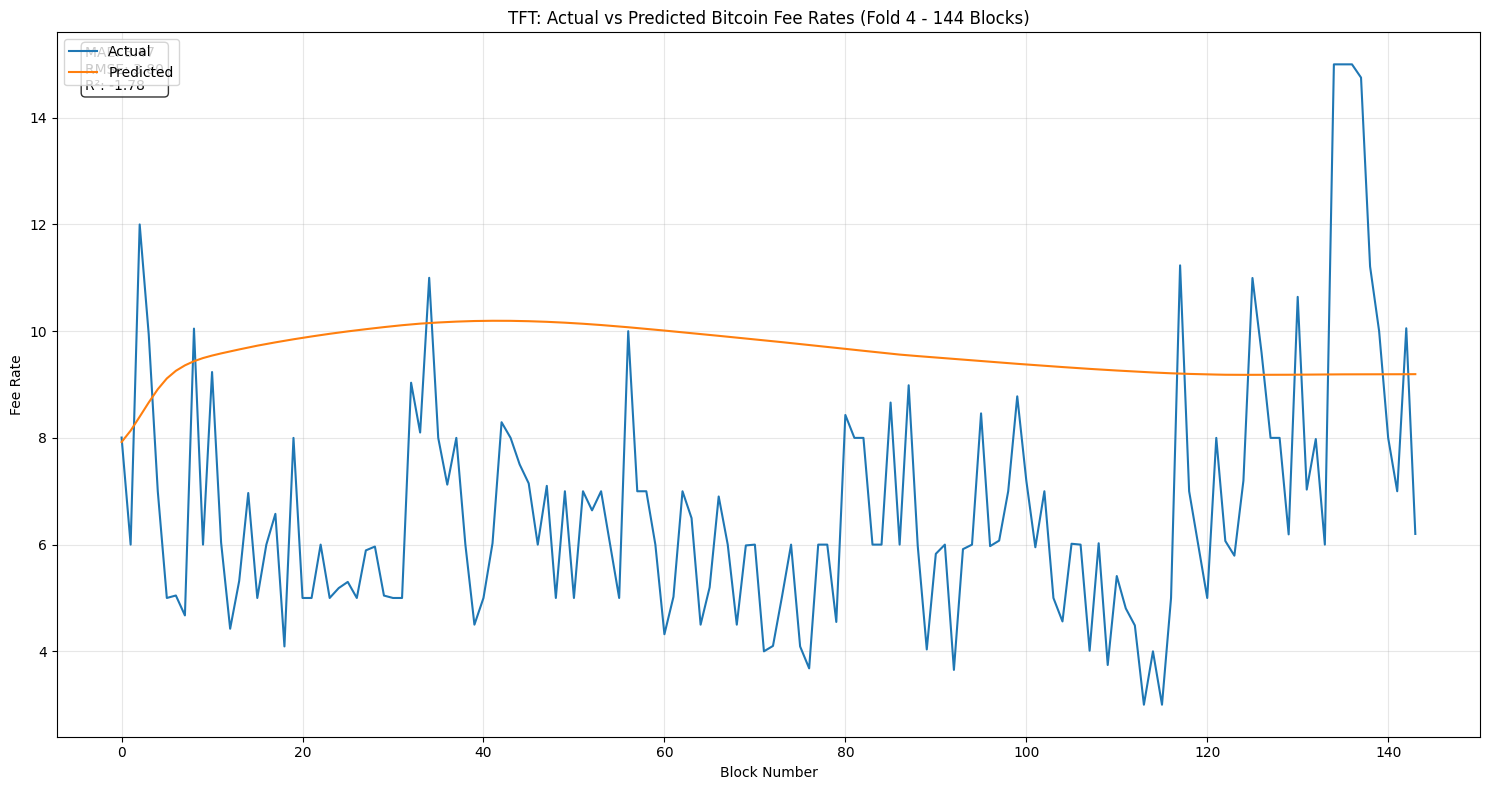


Analyzing feature importance...

Fold 4 Metrics:
MAE: 3.4674
RMSE: 3.8011
R2: -1.7759
MAPE: 62.7794
Theil_U: 0.6144

Training fold 5/5
Fold 5 indices:
Train data: 0 to 11521
Test data: 11233 to 11665
Train data shape: (11521, 32)
Test data shape: (432, 32)
Training on device: cuda
Epoch 5/100
Training Loss: 0.0233
Validation Loss: 0.3900
Epoch 10/100
Training Loss: 0.0117
Validation Loss: 0.3705
Epoch 15/100
Training Loss: 0.0073
Validation Loss: 0.3711
Early stopping triggered
Starting predictions...
Batch 0: Generated 144 predictions
Final predictions shape: (144,)
Final actuals shape: (144,)
Predictions range: [5.69, 14.59]
Actuals range: [3.04, 15.00]
Starting plot function
Original shapes - y_true: (144,), y_pred: (144,)
Number of valid points: 144
Plotting 144 points
y_true range: [3.04, 15.00]
y_pred range: [5.69, 14.59]


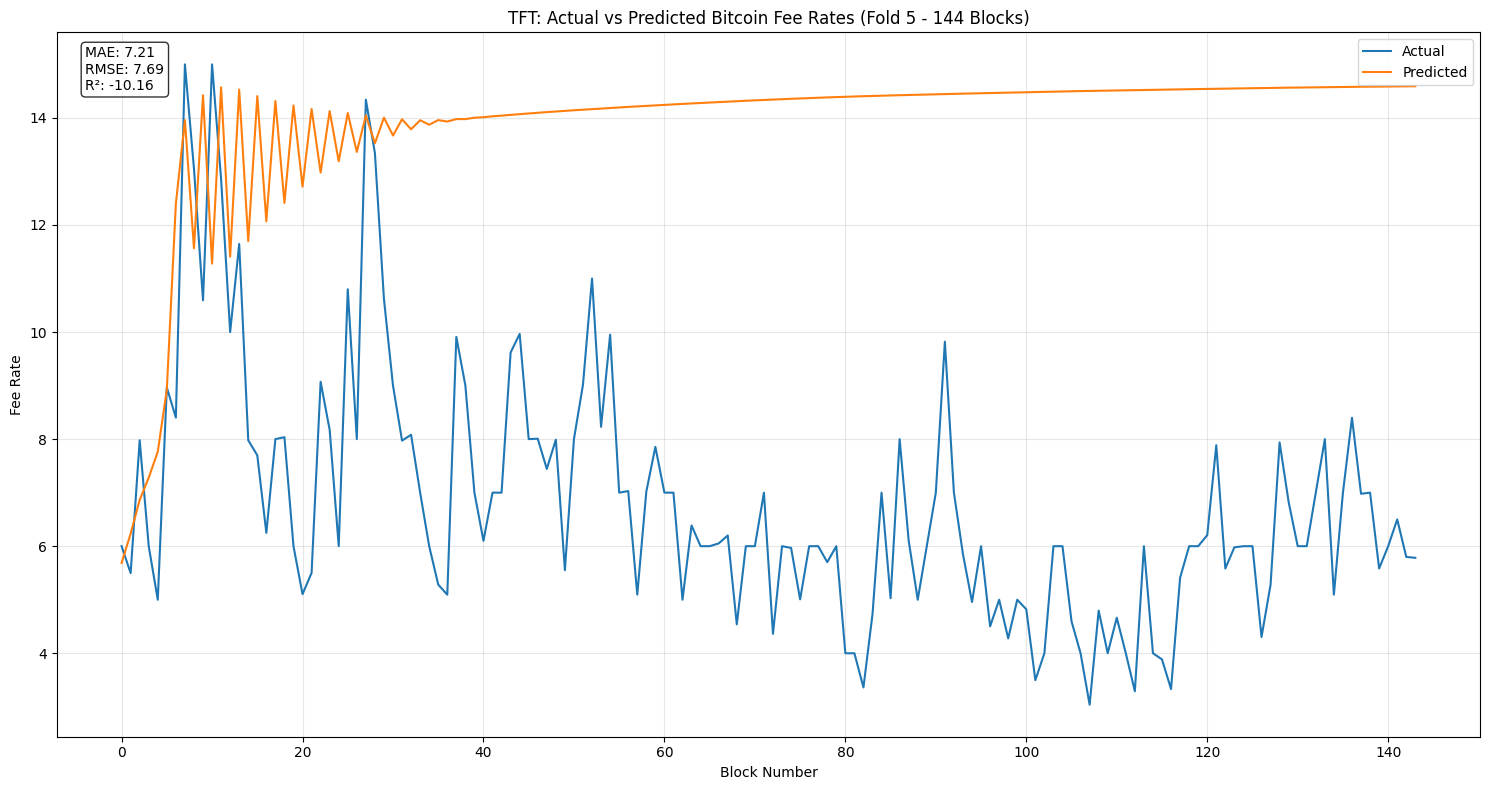


Analyzing feature importance...

Fold 5 Metrics:
MAE: 7.2057
RMSE: 7.6866
R2: -10.1640
MAPE: 127.9785
Theil_U: 0.8091

Average Metrics Across All Folds:
MAE: 4.2583 (±1.4787)
RMSE: 4.8404 (±1.4518)
R2: -3.1049 (±3.6159)
MAPE: 61.9069 (±34.2420)
Theil_U: 0.6528 (±0.0864)


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import time
import random
warnings.filterwarnings('ignore')

def create_time_features(df):
    """Create time-based features from the datetime index"""
    df = df.copy()
    
    # Create cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # Create additional time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(float)
    
    return df

class TemporalFusionTransformerDataset(Dataset):
    def __init__(self, data, static_cols, time_varying_cols, target_col, 
                 encoder_steps=288, decoder_steps=144, is_training=True,
                 scalers=None):  # Add scalers parameter
        self.data = data.copy()
        self.static_cols = static_cols
        self.time_varying_cols = time_varying_cols
        self.target_col = target_col
        self.encoder_steps = encoder_steps
        self.decoder_steps = decoder_steps
        self.is_training = is_training
        self.scalers = scalers if scalers is not None else {}
        
        # Handle missing values
        self.data = self.data.fillna(method='ffill').fillna(method='bfill')
        
        # Scale features
        if scalers is None:
            self._fit_scalers()  # Only fit scalers if not provided
        self._transform_data()  # Always transform data
    
    def _fit_scalers(self):
        """Fit scalers on data (only for training)"""
        for col in self.time_varying_cols + [self.target_col]:
            scaler = StandardScaler()
            scaler.fit(self.data[col].values.reshape(-1, 1))
            self.scalers[col] = scaler
    
    def _transform_data(self):
        """Transform data using scalers"""
        for col in self.time_varying_cols + [self.target_col]:
            self.data[f'{col}_scaled'] = self.scalers[col].transform(
                self.data[col].values.reshape(-1, 1)
            )
            
    def __len__(self):
        """Return the number of available windows"""
        return len(self.data) - self.encoder_steps - self.decoder_steps + 1
    
    def __getitem__(self, idx):
        # Get the window of data
        window_start = idx
        window_end = idx + self.encoder_steps + self.decoder_steps
        window_data = self.data.iloc[window_start:window_end]
        
        # Prepare encoder inputs (historical data)
        encoder_input_data = window_data[[f'{col}_scaled' for col in self.time_varying_cols]]
        encoder_inputs = torch.tensor(
            encoder_input_data.iloc[:self.encoder_steps].values, 
            dtype=torch.float32
        ).transpose(0, 1)
        encoder_inputs = encoder_inputs.unsqueeze(-1)
        
        if self.is_training:
            # For training, use actual future data
            decoder_input_data = window_data[[f'{col}_scaled' for col in self.time_varying_cols]]
            decoder_inputs = torch.tensor(
                decoder_input_data.iloc[self.encoder_steps:].values, 
                dtype=torch.float32
            ).transpose(0, 1)
        else:
            # For testing, use last known values
            last_known_features = encoder_input_data.iloc[-1:]
            decoder_inputs = torch.tensor(
                np.repeat(last_known_features.values, self.decoder_steps, axis=0),
                dtype=torch.float32
            ).transpose(0, 1)
        
        decoder_inputs = decoder_inputs.unsqueeze(-1)
        
        # Prepare target
        target_data = window_data[[f'{self.target_col}_scaled']]
        target = torch.tensor(
            target_data.iloc[self.encoder_steps:].values, 
            dtype=torch.float32
        )
        
        return {
            'encoder_inputs': encoder_inputs.transpose(0, 1),
            'decoder_inputs': decoder_inputs.transpose(0, 1),
            'target': target
        }


class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(output_size)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.linear3 = nn.Linear(input_size, output_size)
        self.linear4 = nn.Linear(output_size, output_size)
        self.dropout_layer = nn.Dropout(dropout)
        
    def forward(self, x):
        skip = self.linear3(x)
        hidden = self.dropout_layer(F.elu(self.linear1(x)))
        hidden = self.linear2(hidden)
        gate = torch.sigmoid(self.linear4(hidden))
        output = self.layer_norm(gate * hidden + skip)
        return output

class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_size, num_inputs, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.num_inputs = num_inputs
        self.variable_grns = nn.ModuleList([
            GatedResidualNetwork(input_size, hidden_size, output_size, dropout)
            for _ in range(num_inputs)
        ])
        self.weight_grn = GatedResidualNetwork(
            num_inputs * input_size, hidden_size, num_inputs, dropout
        )
        
    def forward(self, x):
        batch_size, time_steps, num_features, input_size = x.size()
        x_reshaped = x.view(batch_size * time_steps, num_features, input_size)
        
        var_outputs = []
        for i in range(self.num_inputs):
            processed = self.variable_grns[i](x_reshaped[:, i, :])
            var_outputs.append(processed)
        processed_vars = torch.stack(var_outputs, dim=1)
        
        flat_input = x_reshaped.view(batch_size * time_steps, -1)
        sparse_weights = self.weight_grn(flat_input)
        sparse_weights = torch.softmax(sparse_weights, dim=-1).unsqueeze(-1)
        
        outputs = torch.sum(processed_vars * sparse_weights, dim=1)
        outputs = outputs.view(batch_size, time_steps, -1)
        
        return outputs, sparse_weights

class TemporalFusionTransformer(nn.Module):
    def __init__(self, num_features, hidden_size=128, num_heads=4, 
                 dropout=0.1, num_encoder_layers=3, num_decoder_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        
        # Variable selection networks
        self.encoder_variable_selection = VariableSelectionNetwork(
            input_size=1,
            num_inputs=num_features,
            hidden_size=hidden_size // 2,
            output_size=hidden_size,
            dropout=dropout
        )
        
        self.decoder_variable_selection = VariableSelectionNetwork(
            input_size=1,
            num_inputs=num_features,
            hidden_size=hidden_size // 2,
            output_size=hidden_size,
            dropout=dropout
        )
        
        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True
        )
        
        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True
        )
        
        self.encoder = nn.TransformerEncoder(
            self.encoder_layer,
            num_layers=num_encoder_layers
        )
        
        self.decoder = nn.TransformerDecoder(
            self.decoder_layer,
            num_layers=num_decoder_layers
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, 1)
        
    def forward(self, encoder_inputs, decoder_inputs):
        if len(encoder_inputs.size()) == 3:
            encoder_inputs = encoder_inputs.unsqueeze(-1)
            decoder_inputs = decoder_inputs.unsqueeze(-1)
        
        encoder_processed, encoder_weights = self.encoder_variable_selection(encoder_inputs)
        decoder_processed, decoder_weights = self.decoder_variable_selection(decoder_inputs)
        
        encoder_output = self.encoder(encoder_processed)
        decoder_output = self.decoder(decoder_processed, encoder_output)
        
        predictions = self.output_layer(decoder_output)
        
        return predictions

def train_tft_model(model, train_loader, val_loader, num_epochs=100, 
                   learning_rate=0.001, device='cuda', patience=10):
    print(f"Training on device: {device}")
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            encoder_inputs = batch['encoder_inputs'].to(device)
            decoder_inputs = batch['decoder_inputs'].to(device)
            targets = batch['target'].to(device)
            
            predictions = model(encoder_inputs, decoder_inputs)
            loss = criterion(predictions, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                encoder_inputs = batch['encoder_inputs'].to(device)
                decoder_inputs = batch['decoder_inputs'].to(device)
                targets = batch['target'].to(device)
                
                predictions = model(encoder_inputs, decoder_inputs)
                val_loss += criterion(predictions, targets).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_tft_model_fold.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break
    
    model.load_state_dict(torch.load(f'best_tft_model_fold.pth'))
    return model, train_losses, val_losses

def predict_with_tft(model, dataset, scaler, device='cuda'):
    """Generate predictions with the TFT model using rolling predictions"""
    model.eval()
    predictions = []
    actuals = []
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    
    print("Starting predictions...")
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            encoder_inputs = batch['encoder_inputs'].to(device)
            decoder_inputs = batch['decoder_inputs'].to(device)
            targets = batch['target']
            
            curr_decoder_inputs = decoder_inputs.clone()
            pred_sequence = []
            
            # Generate predictions one step at a time
            for step in range(decoder_inputs.size(1)):
                # Generate prediction for current step
                curr_pred = model(encoder_inputs, curr_decoder_inputs)
                curr_pred = curr_pred[:, step:step+1, :]  # Take only current step prediction
                
                # Store prediction
                pred_scaled = curr_pred.cpu().numpy()
                pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(-1)[0]
                pred_sequence.append(pred)
                
                # Update decoder inputs for next step if not last step
                if step < decoder_inputs.size(1) - 1:
                    # Scale the prediction back to use as next input
                    next_input = torch.tensor(
                        scaler.transform([[pred]]), 
                        dtype=torch.float32, 
                        device=device
                    )
                    # Update the next position in decoder inputs
                    curr_decoder_inputs[0, step+1] = next_input
            
            # Convert predictions to original scale
            actual = scaler.inverse_transform(targets.cpu().numpy().reshape(-1, 1)).reshape(-1)
            
            # Store predictions and actuals
            predictions.extend(pred_sequence)
            actuals.extend(actual)
            
            print(f"Batch {i}: Generated {len(pred_sequence)} predictions")
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    print(f"Final predictions shape: {predictions.shape}")
    print(f"Final actuals shape: {actuals.shape}")
    print(f"Predictions range: [{predictions.min():.2f}, {predictions.max():.2f}]")
    print(f"Actuals range: [{actuals.min():.2f}, {actuals.max():.2f}]")
    
    return predictions, actuals


def analyze_feature_importance(model, test_loader, device, feature_names):
    """Analyze which features are most important for predictions"""
    model.eval()
    feature_importance = []
    
    with torch.no_grad():
        for batch in test_loader:
            encoder_inputs = batch['encoder_inputs'].to(device)
            decoder_inputs = batch['decoder_inputs'].to(device)
            
            # Get attention weights from variable selection networks
            _, encoder_weights = model.encoder_variable_selection(encoder_inputs)
            _, decoder_weights = model.decoder_variable_selection(decoder_inputs)
            
            # Properly reshape and average the weights
            encoder_weights = encoder_weights.squeeze(-1).mean(dim=0).cpu().numpy()
            decoder_weights = decoder_weights.squeeze(-1).mean(dim=0).cpu().numpy()
            
            feature_importance.append((encoder_weights + decoder_weights) / 2)
    
    # Average across all batches
    avg_importance = np.mean(feature_importance, axis=0)
    
    return avg_importance

def evaluate_predictions(y_true, y_pred):
    """Calculate and return evaluation metrics"""
    # Remove pairs where either value is invalid
    mask = ~(np.isnan(y_true) | np.isnan(y_pred) | 
             np.isinf(y_true) | np.isinf(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return {
            'MAE': float('nan'),
            'RMSE': float('nan'),
            'R2': float('nan'),
            'MAPE': float('nan'),
            'Theil_U': float('nan')
        }
    
    # Calculate basic metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
# Evaluation Metrics
    def mean_absolute_percentage_error(y_true, y_pred):
        """Calculate Mean Absolute Percentage Error with proper handling of types"""
        y_true = np.array(y_true).astype(float)
        y_pred = np.array(y_pred).astype(float)
    
    # Handle division by zero
        mask = y_true != 0
        if not np.any(mask):
            return float('inf')
    
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    def directional_accuracy(y_true, y_pred):
        """Calculate Directional Accuracy"""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

    def theil_u(y_true, y_pred):
        """Calculate Theil's U statistic"""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
    
        y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
        y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
    
        numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
        denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
        return numerator / denominator
    mape = mean_absolute_percentage_error(y_true, y_pred)
    theil_u = theil_u(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Theil_U': theil_u
    }



def plot_predictions(y_true, y_pred, title="Bitcoin Fee Rate Predictions", show_last_n=144):
    """Plot actual vs predicted values"""
    print("Starting plot function")
    print(f"Original shapes - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
    
    # Handle invalid values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred) | 
             np.isinf(y_true) | np.isinf(y_pred))
    
    print(f"Number of valid points: {np.sum(mask)}")
    
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        print("No valid data points to plot!")
        return
        
    # Use the last show_last_n points
    if len(y_true) > show_last_n:
        y_true = y_true[-show_last_n:]
        y_pred = y_pred[-show_last_n:]
    
    print(f"Plotting {len(y_true)} points")
    print(f"y_true range: [{y_true.min():.2f}, {y_true.max():.2f}]")
    print(f"y_pred range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")
    
    # Create plot
    plt.figure(figsize=(15, 8))
    x_axis = np.arange(len(y_true))
    
    plt.plot(x_axis, y_true, label='Actual')
    plt.plot(x_axis, y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add error metrics
    if len(y_true) > 1:
        stats_text = f'MAE: {mean_absolute_error(y_true, y_pred):.2f}\n'
        stats_text += f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}\n'
        stats_text += f'R²: {r2_score(y_true, y_pred):.2f}'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


def cross_validate_tft(df, n_splits=5, encoder_steps=288, decoder_steps=144):
    print("Starting cross-validation...")
    
    n_total = len(df)
    test_size = decoder_steps
    
    # Define features
    time_varying_cols = [
        # Mempool metrics
        'mempool_size_mb', 
        'mempool_min_fee',
        'mempool_usage',
        'total_fee',
        
        # Fee statistics
        'avg_fee_rate',
        'median_fee_rate',
        'fee_rate_10th',
        'fee_rate_90th',
        'fee_rate_std',
        
        # Transaction metrics
        'tx_count',
        'transaction_count',
        
        # Block metrics
        'block_interval',
        'block_weight',
        
        # Network metrics
        'difficulty',
        'hash_rate',
        
        # Price metrics
        'bitcoin_price_usd',
        
        # Historical fee ratios
        'hist_low_fee_ratio',
        'hist_med_fee_ratio',
        'hist_high_fee_ratio',
        'hist_fee_diversity',
        
        # Time features
        'hour_sin', 'hour_cos', 
        'day_sin', 'day_cos',
        'hour', 'dayofweek', 
        'is_weekend'
    ]
    
    # Store metrics and predictions
    all_metrics = []
    fold_predictions = []
    
    for fold_idx in range(n_splits):
        print(f"\nTraining fold {fold_idx+1}/{n_splits}")
        
        # Calculate indices for sequential split
        train_end = n_total - (n_splits - fold_idx) * test_size
        test_start = train_end - encoder_steps
        test_end = train_end + test_size
        
        print(f"Fold {fold_idx + 1} indices:")
        print(f"Train data: 0 to {train_end}")
        print(f"Test data: {test_start} to {test_end}")
        
        # Create train/test splits
        train_data = df.iloc[:train_end].copy()
        test_data = df.iloc[test_start:test_end].copy()
        
        print(f"Train data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        # Create training dataset with fitted scalers
        train_dataset = TemporalFusionTransformerDataset(
            data=train_data,
            static_cols=[],
            time_varying_cols=time_varying_cols,
            target_col='block_median_fee_rate',
            encoder_steps=encoder_steps,
            decoder_steps=decoder_steps,
            is_training=True,
            scalers=None  # Fit new scalers on training data
        )
        
        # Create test dataset using scalers from training
        test_dataset = TemporalFusionTransformerDataset(
            data=test_data,
            static_cols=[],
            time_varying_cols=time_varying_cols,
            target_col='block_median_fee_rate',
            encoder_steps=encoder_steps,
            decoder_steps=decoder_steps,
            is_training=False,  # Don't use future values for testing
            scalers=train_dataset.scalers  # Use scalers fitted on training data
        )
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=32,
            shuffle=True,
            num_workers=0
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=32,
            shuffle=False,
            num_workers=0
        )


# Best Hyperparameters: {'hidden_size': 64, 'num_heads': 4, 'dropout': 0.25990861704137086,
#                        'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.0007495290955732481}
        
        # Initialize and train model
        num_features = len(time_varying_cols)
        model = TemporalFusionTransformer(
            num_features=num_features,
            hidden_size=64,
            num_heads=4, 
            dropout=0.25990861704137086, 
            num_encoder_layers=3,
            num_decoder_layers=4   
        )
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        trained_model, train_losses, val_losses = train_tft_model(
            model,
            train_loader,
            test_loader,
            num_epochs=100,
            learning_rate=0.0007495290955732481,
            device=device,
            patience=10
        )

        
        # Generate predictions using training scalers
        predictions, actuals = predict_with_tft(
            trained_model,
            test_dataset,
            train_dataset.scalers['block_median_fee_rate'],  # Use training scaler
            device=device
        )
        
        # Calculate metrics
        fold_metrics = evaluate_predictions(actuals, predictions)
        all_metrics.append(fold_metrics)
        
        fold_predictions.append({
            'predictions': predictions,
            'actuals': actuals,
            'test_indices': list(range(test_start, test_end))
        })
        
        # Plot predictions
        plot_predictions(
            actuals,
            predictions,
            title=f"TFT: Actual vs Predicted Bitcoin Fee Rates (Fold {fold_idx + 1} - {test_size} Blocks)"
        )
        
        # Analyze feature importance
        print("\nAnalyzing feature importance...")
        feature_importance = analyze_feature_importance(
            trained_model, 
            test_loader, 
            device,
            time_varying_cols
        )
        
        print(f"\nFold {fold_idx + 1} Metrics:")
        for metric_name, value in fold_metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    # Calculate and print average metrics
    print("\nAverage Metrics Across All Folds:")
    avg_metrics = {}
    std_metrics = {}
    
    for metric in all_metrics[0].keys():
        values = [fold[metric] for fold in all_metrics]
        avg_metrics[metric] = np.mean(values)
        std_metrics[metric] = np.std(values)
        print(f"{metric}: {avg_metrics[metric]:.4f} (±{std_metrics[metric]:.4f})")
    
    return {
        'fold_metrics': all_metrics,
        'average_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'fold_predictions': fold_predictions
    }


def plot_all_folds_combined(fold_predictions, title="TFT: Actual vs Predicted Bitcoin Fee Rates (All Folds)"):
    """Plot all folds' predictions and actual values on the same plot."""
    combined_actuals = []
    combined_predictions = []
    
    # Combine all folds' predictions and actuals
    for fold in fold_predictions:
        combined_actuals.extend(fold['actuals'])
        combined_predictions.extend(fold['predictions'])
    
    # Convert to numpy arrays for plotting
    combined_actuals = np.array(combined_actuals)
    combined_predictions = np.array(combined_predictions)
    
    # Plot
    plt.figure(figsize=(15, 12))
    x_axis = np.arange(1,len(combined_actuals)+1)  # Use the combined length as the x-axis
    plt.plot(x_axis, combined_actuals, label="Actual")
    plt.plot(x_axis, combined_predictions, label="Predicted")
    
    plt.title(title,fontsize=20)
    plt.xlabel("Block Number",fontsize=20)
    plt.ylabel("Fee Rate",fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.savefig('/kaggle/working/TFT.png',dpi=600)
    plt.show()


def main():
    try:
        # Load data
        print("Loading data...")
        df = pd.read_csv('/kaggle/input/tft-bitcoin/train_set.csv')
        df['block_time'] = pd.to_datetime(df['block_time'])
        df = df.sort_values('block_time').set_index('block_time')
        
        # Create time features
        df = create_time_features(df)
        
        # Perform cross-validation
        results = cross_validate_tft(
            df,
            n_splits=5,
            encoder_steps=288,  # 48 hours of history
            decoder_steps=144   # 24 hours of prediction
        )
        
        # Plot all folds combined
        plot_all_folds_combined(results['fold_predictions'])
        
        print("Training and evaluation complete!")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)

if __name__ == "__main__":
    # Set random seed and start timer
    set_seed(42)
    start = time.time()
    main()
    # Print execution time
    end = time.time()
    print(f"\nTotal execution time: {end-start:.2f} seconds")



## Train the Model on the Entire Dataset to Predict the Next 144 Blocks and Compare with Actual Values

Loading data...
Starting prediction process...

Initializing model with best parameters...

Training model on full dataset...
Training on device: cuda
Epoch 5/100
Training Loss: 0.0246
Validation Loss: 0.0170
Epoch 10/100
Training Loss: 0.0121
Validation Loss: 0.0081
Epoch 15/100
Training Loss: 0.0074
Validation Loss: 0.0052
Epoch 20/100
Training Loss: 0.0051
Validation Loss: 0.0030
Epoch 25/100
Training Loss: 0.0039
Validation Loss: 0.0024
Epoch 30/100
Training Loss: 0.0042
Validation Loss: 0.0022
Epoch 35/100
Training Loss: 0.0025
Validation Loss: 0.0022
Epoch 40/100
Training Loss: 0.0023
Validation Loss: 0.0015
Epoch 45/100
Training Loss: 0.0020
Validation Loss: 0.0016
Epoch 50/100
Training Loss: 0.0025
Validation Loss: 0.0014
Epoch 55/100
Training Loss: 0.0017
Validation Loss: 0.0015
Epoch 60/100
Training Loss: 0.0015
Validation Loss: 0.0012
Epoch 65/100
Training Loss: 0.0013
Validation Loss: 0.0012
Epoch 70/100
Training Loss: 0.0012
Validation Loss: 0.0010
Epoch 75/100
Training Lo

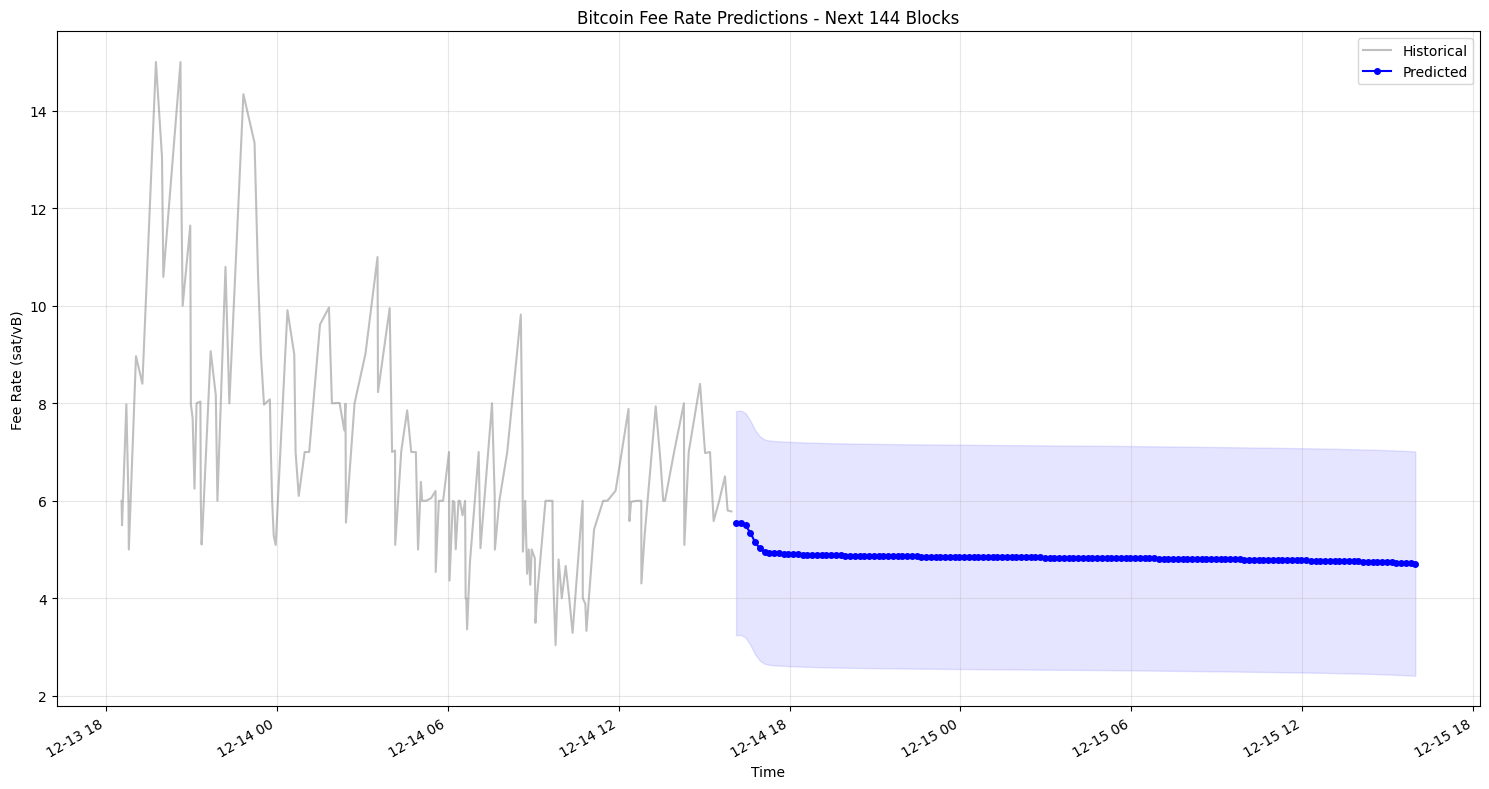


Prediction Statistics:
Mean predicted fee rate: 4.85 sat/vB
Min predicted fee rate: 4.71 sat/vB
Max predicted fee rate: 5.55 sat/vB


In [6]:
def predict_future_fees_tft(df, prediction_blocks=144, encoder_steps=288):
    """Train TFT model on full dataset and predict future fee rates"""
    try:
        print("Starting prediction process...")
        
        # Create time features
        df = create_time_features(df)
        
        # Define features
        time_varying_cols = [
            # Mempool metrics
            'mempool_size_mb', 
            'mempool_min_fee',
            'mempool_usage',
            'total_fee',
            
            # Fee statistics
            'avg_fee_rate',
            'median_fee_rate',
            'fee_rate_10th',
            'fee_rate_90th',
            'fee_rate_std',
            
            # Transaction metrics
            'tx_count',
            'transaction_count',
            
            # Block metrics
            'block_interval',
            'block_weight',
            
            # Network metrics
            'difficulty',
            'hash_rate',
            
            # Price metrics
            'bitcoin_price_usd',
            
            # Historical fee ratios
            'hist_low_fee_ratio',
            'hist_med_fee_ratio',
            'hist_high_fee_ratio',
            'hist_fee_diversity',
            
            # Time features
            'hour_sin', 'hour_cos', 
            'day_sin', 'day_cos',
            'hour', 'dayofweek', 
            'is_weekend'
        ]
        
        # Create training dataset
        train_dataset = TemporalFusionTransformerDataset(
            data=df,
            static_cols=[],
            time_varying_cols=time_varying_cols,
            target_col='block_median_fee_rate',
            encoder_steps=encoder_steps,
            decoder_steps=prediction_blocks,
            is_training=True
        )
        
        # Create data loader
        train_loader = DataLoader(
            train_dataset,
            batch_size=32,
            shuffle=True,
            num_workers=0
        )

# Best Hyperparameters: {'hidden_size': 64, 'num_heads': 4, 'dropout': 0.25990861704137086,
#                        'num_encoder_layers': 3, 'num_decoder_layers': 4, 'learning_rate': 0.0007495290955732481}
   
        
        
        # Initialize model with best parameters
        print("\nInitializing model with best parameters...")
        num_features = len(time_varying_cols)
        model = TemporalFusionTransformer(
            num_features=num_features,
            hidden_size=64,
            num_heads=4,
            dropout=0.25990861704137086,
            num_encoder_layers=3,
            num_decoder_layers=4
        )
        
        # Train model
        print("\nTraining model on full dataset...")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model, train_losses, _ = train_tft_model(
            model,
            train_loader,
            train_loader,  # Using same loader for validation
            num_epochs=100,
            learning_rate=0.0007495290955732481,
            device=device,
            patience=10
        )
        
        # Prepare last window of data for prediction
        last_window = df.iloc[-encoder_steps:].copy()
        # Add decoder steps with repeated last values
        future_window = pd.DataFrame(index=pd.date_range(
            start=df.index[-1] + pd.Timedelta(minutes=10),
            periods=prediction_blocks,
            freq='10T'
        ))
        
        # Fill future window with last known values
        for col in time_varying_cols:
            future_window[col] = df[col].iloc[-1]
        
        # Update time features for future window
        future_window = create_time_features(future_window)
        
        # Combine last window and future window
        prediction_data = pd.concat([last_window, future_window])
        
        # Create prediction dataset
        pred_dataset = TemporalFusionTransformerDataset(
            data=prediction_data,
            static_cols=[],
            time_varying_cols=time_varying_cols,
            target_col='block_median_fee_rate',
            encoder_steps=encoder_steps,
            decoder_steps=prediction_blocks,
            is_training=False,
            scalers=train_dataset.scalers
        )
        
        # Generate predictions
        print("\nGenerating predictions for next 144 blocks...")
        predictions, _ = predict_with_tft(
            model,
            pred_dataset,
            train_dataset.scalers['block_median_fee_rate'],
            device=device
        )
        
        # Create results DataFrame
        results_df = pd.DataFrame({
            'timestamp': future_window.index,
            'predicted_fee_rate': predictions[:prediction_blocks]
        })
        
        # Plot predictions with historical context
        plt.figure(figsize=(15, 8))
        
        # Plot historical data (last 24 hours)
        historical_data = df['block_median_fee_rate'].iloc[-144:]
        plt.plot(historical_data.index, historical_data.values, 
                label='Historical', color='gray', alpha=0.5)
        
        # Plot predictions
        plt.plot(results_df['timestamp'], results_df['predicted_fee_rate'], 
                label='Predicted', color='blue', marker='o', markersize=4)
        
        plt.title('Bitcoin Fee Rate Predictions - Next 144 Blocks')
        plt.xlabel('Time')
        plt.ylabel('Fee Rate (sat/vB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Format x-axis
        plt.gcf().autofmt_xdate()
        
        # Add confidence bands
        std_dev = np.std(historical_data)
        plt.fill_between(
            results_df['timestamp'],
            results_df['predicted_fee_rate'] - std_dev,
            results_df['predicted_fee_rate'] + std_dev,
            color='blue', alpha=0.1, label='±1σ Confidence'
        )
        
        plt.tight_layout()
        plt.show()
        
        # Print prediction statistics
        print("\nPrediction Statistics:")
        print(f"Mean predicted fee rate: {results_df['predicted_fee_rate'].mean():.2f} sat/vB")
        print(f"Min predicted fee rate: {results_df['predicted_fee_rate'].min():.2f} sat/vB")
        print(f"Max predicted fee rate: {results_df['predicted_fee_rate'].max():.2f} sat/vB")
        
        return results_df
        
    except Exception as e:
        print(f"Error in prediction process: {str(e)}")
        raise

def main():
    try:
        # Load and preprocess data
        print("Loading data...")
        df = pd.read_csv('/kaggle/input/tft-bitcoin/train_set.csv')
        df['block_time'] = pd.to_datetime(df['block_time'])
        df = df.sort_values('block_time').set_index('block_time')
        
        # Generate predictions
        predictions_df = predict_future_fees_tft(df, prediction_blocks=144)
        
        return predictions_df
        
    except Exception as e:
        print(f"Error in main process: {str(e)}")
        raise

if __name__ == "__main__":
    set_seed(42)  # Set random seed for reproducibility
    predictions_df = main()

Performance Metrics:
Mean Absolute Error (MAE): 1.5111
Root Mean Squared Error (RMSE): 1.9171
Theil's U Statistic: 0.5459


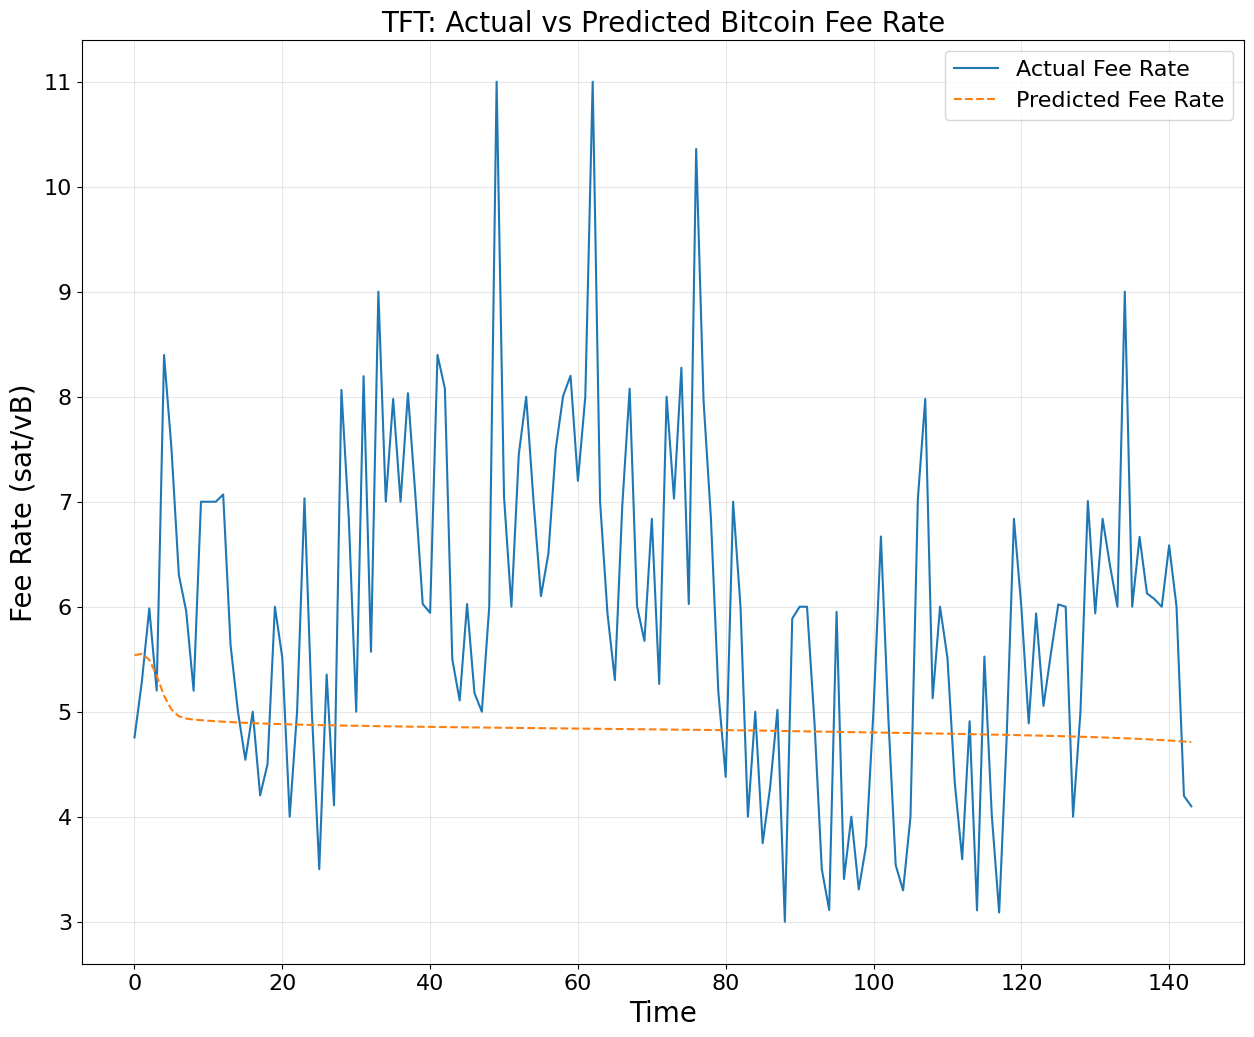

In [7]:
# Load test and prediction data    

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
    
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator


# Load test and prediction data    
sf = pd.read_csv('/kaggle/input/tft-bitcoin/test_set.csv')
actual_values = sf['block_median_fee_rate']
predicted_values = predictions_df['predicted_fee_rate']

# Calculate metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
theils_u_value = theil_u(actual_values.values, predicted_values.values)

# Print metrics
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Theil's U Statistic: {theils_u_value:.4f}")


# Create plot
plt.figure(figsize=(15, 12))

# Plot actual values
plt.plot(actual_values.index, actual_values, 
         label='Actual Fee Rate')

# Plot predicted values
plt.plot(actual_values.index, predicted_values, 
         label='Predicted Fee Rate', linestyle='--')


# Add title and labels
plt.title('TFT: Actual vs Predicted Bitcoin Fee Rate', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Fee Rate (sat/vB)', fontsize=20)

# Add legend and grid
plt.legend(fontsize=16)
plt.grid(alpha=0.3)

plt.xticks( fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('TFT_test.png',dpi=600)

# Show plot
plt.show()
